In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import metpy.calc as mpcalc

from metpy.interpolate import cross_section

In [12]:
data = xr.open_dataset(get_test_data('narr_example.nc', False))
data = data.metpy.parse_cf().squeeze()
print(data)

<xarray.Dataset>
Dimensions:              (isobaric: 29, x: 292, y: 118)
Coordinates:
    time                 datetime64[ns] 1987-04-04T18:00:00
  * isobaric             (isobaric) float64 1e+03 975.0 950.0 ... 125.0 100.0
  * y                    (y) float64 -3.087e+06 -3.054e+06 ... 7.114e+05
  * x                    (x) float64 -3.977e+06 -3.945e+06 ... 5.47e+06
    crs                  object Projection: lambert_conformal_conic
Data variables:
    Temperature          (isobaric, y, x) float32 ...
    Lambert_Conformal    |S1 ...
    lat                  (y, x) float64 ...
    lon                  (y, x) float64 ...
    u_wind               (isobaric, y, x) float32 ...
    v_wind               (isobaric, y, x) float32 ...
    Geopotential_height  (isobaric, y, x) float32 ...
    Specific_humidity    (isobaric, y, x) float32 ...


In [13]:
start = (37.0, -105.0)
end = (35.5, -65.0)

In [14]:
cross = cross_section(data, start, end)
cross.set_coords(('lat', 'lon'), True)
print(cross)

<xarray.Dataset>
Dimensions:              (index: 100, isobaric: 29)
Coordinates:
    time                 datetime64[ns] 1987-04-04T18:00:00
  * isobaric             (isobaric) float64 1e+03 975.0 950.0 ... 125.0 100.0
    crs                  object Projection: lambert_conformal_conic
    x                    (index) float64 1.818e+05 2.18e+05 ... 3.712e+06
    y                    (index) float64 -1.454e+06 -1.447e+06 ... -5.573e+05
  * index                (index) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    lat                  (index) float64 37.0 37.05 37.11 ... 35.66 35.58 35.5
    lon                  (index) float64 -105.0 -104.6 -104.2 ... -65.39 -65.0
Data variables:
    Temperature          (isobaric, index) float64 287.7 286.9 ... 211.4 211.4
    Lambert_Conformal    |S1 ...
    u_wind               (isobaric, index) float64 -2.729 0.4776 ... 24.6 23.68
    v_wind               (isobaric, index) float64 8.473 5.723 ... -1.082
    Geopotential_height  (isobaric, inde

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.
  


In [15]:
temperature, pressure, specific_humidity = xr.broadcast(cross['Temperature'],
                                                        cross['isobaric'],
                                                        cross['Specific_humidity'])

theta = mpcalc.potential_temperature(pressure, temperature)
rh = mpcalc.relative_humidity_from_specific_humidity(specific_humidity, temperature, pressure)

# These calculations return unit arrays, so put those back into DataArrays in our Dataset
cross['Potential_temperature'] = xr.DataArray(theta,
                                              coords=temperature.coords,
                                              dims=temperature.dims,
                                              attrs={'units': theta.units})
cross['Relative_humidity'] = xr.DataArray(rh,
                                          coords=specific_humidity.coords,
                                          dims=specific_humidity.dims,
                                          attrs={'units': rh.units})

cross['u_wind'].metpy.convert_units('knots')
cross['v_wind'].metpy.convert_units('knots')
cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(cross['u_wind'],
                                                                   cross['v_wind'])

print(cross)

<xarray.Dataset>
Dimensions:                (index: 100, isobaric: 29)
Coordinates:
    time                   datetime64[ns] 1987-04-04T18:00:00
  * isobaric               (isobaric) float64 1e+03 975.0 950.0 ... 125.0 100.0
    crs                    object Projection: lambert_conformal_conic
    x                      (index) float64 1.818e+05 2.18e+05 ... 3.712e+06
    y                      (index) float64 -1.454e+06 -1.447e+06 ... -5.573e+05
  * index                  (index) int64 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
    lat                    (index) float64 37.0 37.05 37.11 ... 35.66 35.58 35.5
    lon                    (index) float64 -105.0 -104.6 -104.2 ... -65.39 -65.0
Data variables:
    Temperature            (isobaric, index) float64 287.7 286.9 ... 211.4 211.4
    Lambert_Conformal      |S1 ...
    u_wind                 (isobaric, index) float64 -5.304 0.9285 ... 46.03
    v_wind                 (isobaric, index) float64 16.47 11.13 ... -2.104
    Geopotential_heig

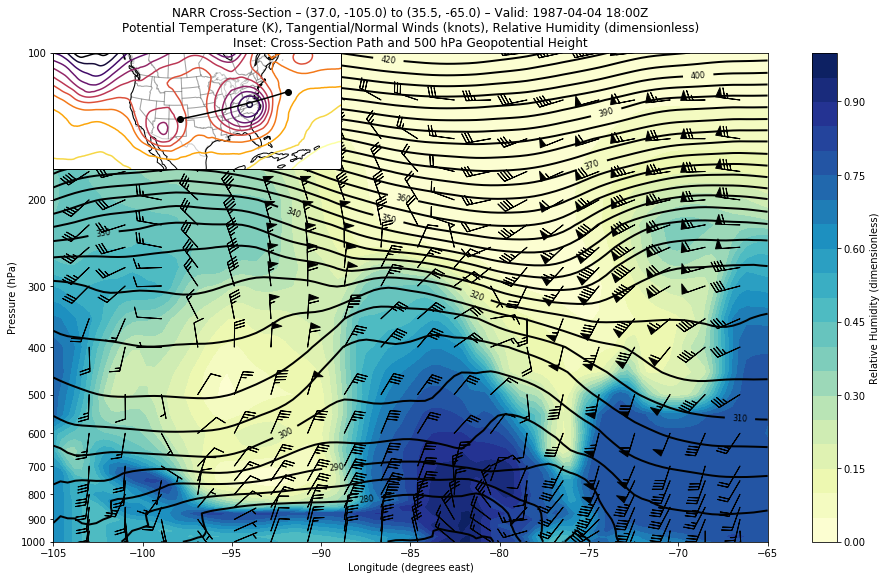

In [16]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(cross['lon'], cross['isobaric'], cross['Relative_humidity'],
                         levels=np.arange(0, 1.05, .05), cmap='YlGnBu')
rh_colorbar = fig.colorbar(rh_contour)

# Plot potential temperature using contour, with some custom labeling
theta_contour = ax.contour(cross['lon'], cross['isobaric'], cross['Potential_temperature'],
                           levels=np.arange(250, 450, 5), colors='k', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot winds using the axes interface directly, with some custom indexing to make the barbs
# less crowded
wind_slc_vert = list(range(0, 19, 2)) + list(range(19, 29))
wind_slc_horz = slice(5, 100, 5)
ax.barbs(cross['lon'][wind_slc_horz], cross['isobaric'][wind_slc_vert],
         cross['t_wind'][wind_slc_vert, wind_slc_horz],
         cross['n_wind'][wind_slc_vert, wind_slc_horz], color='k')

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_ylim(cross['isobaric'].max(), cross['isobaric'].min())
ax.set_yticks(np.arange(1000, 50, -100))

# Define the CRS and inset axes
data_crs = data['Geopotential_height'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=data_crs)

# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(data['x'], data['y'], data['Geopotential_height'].sel(isobaric=500.),
                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['x'], cross['y'], c='k', zorder=2)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
ax.set_title('NARR Cross-Section \u2013 {} to {} \u2013 Valid: {}\n'
             'Potential Temperature (K), Tangential/Normal Winds (knots), '
             'Relative Humidity (dimensionless)\n'
             'Inset: Cross-Section Path and 500 hPa Geopotential Height'.format(
                 start, end, cross['time'].dt.strftime('%Y-%m-%d %H:%MZ').item()))
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
rh_colorbar.set_label('Relative Humidity (dimensionless)')

plt.show()
